# Computer Vision
# Level 3

#### Kyle Stahl
#### Feb. 2018

## **Introduction**

This is the third installment in a 3-part (more to come in progress so actually 4 part) series on creating computer vision algorithms for the MNIST data set. The first (https://www/kyle-stahl-mn.com/computer-vision-1) used ten logistic regression models to differentiate between the ten different digits. The second (https://www/kyle-stahl-mn.com/computer-vision-2) used a neural network implemented in scikit learn. And now we are moving onto convolutional neural networks, and implementing it in Keras.

Keras is a high level python deep learning frame work that can run on top of popular deep learning libraries such as TensorFlow, CNTK, and Theano. I am running it with tensorflow on the back-end and running it on my GPU. It gets complicated making sure that you have everything installed for tensorflow to recognize the GPU on your device, but if you follow the instructions on this page you should be fine: https://www.tensorflow.org/install/install_windows. To check that it is recognizing the GPU run: 

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()[1]) 
#https://stackoverflow.com/questions/44544766/how-do-i-check-if-keras-is-using-gpu-version-of-tensorflow

name: "/gpu:0"
device_type: "GPU"
memory_limit: 1573250662
locality {
  bus_id: 1
}
incarnation: 14035979373787638431
physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:01:00.0"



Convolutional Neural Networks are similar to the traditional neural network in the previous tutorial, but tries to take advantage of spatial relationships between the pixels in the image. In the previous representation of the data, you could mix around the columns of pixels, and it would have no effect on the model performance. In other words, the order of your variables did not matter. But with convolution nets, the location of the pixels in relation to each other is very significant; which is why they are so efficient for image recognition problems. I will again spare you the break down of the mathemtics to focus on the coding part. If you are interested more in the math, the resource that I found the most useful is this lecture from Stanford: https://www.youtube.com/watch?v=AQirPKrAyDg

## **Import Packages and Modules**

In [2]:
import numpy as np
import pandas as pd

# Change directory to where the photos are downloaded
import os
os.chdir("C:\\Users\\kyles\\Downloads\\TrainingSet")

# OpenCV package will be used to bring images in as numpy arrays
import cv2

# tqdm is used to track the progress of loops
from tqdm import tqdm

# Deep Learning Framework
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# For Images and graphing
from matplotlib import pyplot as plt

Using TensorFlow backend.


## **Read and Clean Data**

For a walk through on what is happening with this loop to import the data, check out tutorial 1 here (https://www/kyle-stahl-mn.com/computer-vision-1). The end product for this data is slightly different than the last two. This is because Sci-kit learn needs the data to be in pandas `DataFrame` or `Series` objects while Keras needs the data to be in numpy arrays. 

Here we are storing the data in a 3-D 28x28x42,000 array. 28x28 for the pixel values, and 42,000 images. The input then needs to be reshaped into a 4-D array either 1x42000x28x28 or 42000x28x28x1 depending on the `image_data_format()` setting shown in a comment below. And at this official Keras walk through https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py.

In [3]:
"""if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)"""

data = np.zeros([42000,28,28])
label = []
for i in tqdm(range(42000)):
    img = cv2.imread("0/img_" + str(i) + ".jpg")
    if img is not None:
        data[i,:,:] = img.mean(axis = 2)
        label.append(0)
        continue
    img = cv2.imread("1/img_" + str(i) + ".jpg")
    if img is not None:
        data[i,:,:] = img.mean(axis = 2)
        label.append(1)
        continue
    img = cv2.imread("2/img_" + str(i) + ".jpg")
    if img is not None:
        data[i,:,:] = img.mean(axis = 2)
        label.append(2)
        continue
    img = cv2.imread("3/img_" + str(i) + ".jpg")
    if img is not None:
        data[i,:,:] = img.mean(axis = 2)
        label.append(3)
        continue
    img = cv2.imread("4/img_" + str(i) + ".jpg")
    if img is not None:
        data[i,:,:] = img.mean(axis = 2)
        label.append(4)
        continue
    img = cv2.imread("5/img_" + str(i) + ".jpg")
    if img is not None:
        data[i,:,:] = img.mean(axis = 2)
        label.append(5)
        continue
    img = cv2.imread("6/img_" + str(i) + ".jpg")
    if img is not None:
        data[i,:,:] = img.mean(axis = 2)
        label.append(6)
        continue    
    img = cv2.imread("7/img_" + str(i) + ".jpg")
    if img is not None:
        data[i,:,:] = img.mean(axis = 2)
        label.append(7)
        continue
    img = cv2.imread("8/img_" + str(i) + ".jpg")
    if img is not None:
        data[i,:,:] = img.mean(axis = 2)
        label.append(8)
        continue
    img = cv2.imread("9/img_" + str(i) + ".jpg")
    if img is not None:
        data[i,:,:] = img.mean(axis = 2)
        label.append(9)
        continue

X = data.reshape(42000,28,28,1)
Y = np.array(label)

100%|███████████████████████████████████████████████████████████████████████████| 42000/42000 [00:59<00:00, 704.10it/s]


Here I will just show a random image and the shapes of the X and Y arrays.

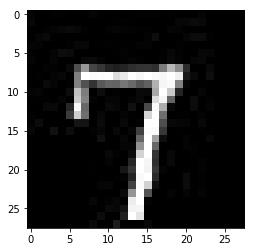

(42000, 28, 28, 1)


(42000,)

In [4]:
plt.imshow(data[6,:,:],cmap='gray')
plt.show()
print(X.shape)
Y.shape

Now similarly to the previous two examples, we need to do a train/test split, scale the X variables (pixel values) and binarize the Y variables (digit written on the image). But now all of these tasks are done with numpy instead of scikit-learn. I am going to take the same size training sample as the prior two tutorial to get an apples-to-apples comparison on accuracy.

In [5]:
# Randomly select images for training set.
ix = np.random.choice(42000, round(42000*0.6), replace=False)

# Binarize Dependent Variable
Y = np.array(label)
Y = keras.utils.to_categorical(Y, 10)

# Split into training and test.
# And scale variables to be [0,1] 
Xtrain = X[ix,:,:,:] / 255.0
Xtest = np.delete(X,ix, axis=0) / 255.0

Ytrain = Y[ix,:]
Ytest = np.delete(Y,ix,axis=0)

Many of the same parameters as before still apply to convolutional neural networks. The specific structure of the network is defined as it is built with the `.add()` method. With deep neural networks, it is best practice to use 'ReLu' activation functions to avoid the vanishing gradient problem (https://www.quora.com/What-is-the-vanishing-gradient-problem); until the last layer where the sigmoid function transforms the outputs to be [0,1] probabilities. 

There are two main steps to CNN's convolution layers, and pooling layers. For a good explanation of the how/why these work, i would suggest perusing this guide: https://deeplearning4j.org/convolutionalnetwork. These layers are traditionally followed by a _"fully connected"_ layer at the very end, which is essentially the same as network created my previous walk through (https://www/kyle-stahl-mn.com/computer-vision-2). 

One thing that I did not cover last time was the concept of batch training, iterations, and epochs. An `epoch` is when the entire dataset has had a forward and backward pass in the model. An `iteration` is a forward/backward pass of one `batch`. So if your entire data set has 1,000 observations, and you set the `batch_size` to 25, it will take 400 `iterations` for 1 `epoch`. Generally, more epochs will be more accurate (unless you overfit) and more time consuming. And smaller batch sizes will also be more time consuming, but are believe to be more accurate. For more information on this I suggest reviewing this overview: https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/

In [6]:
# Model Parameters
batch_size = 256
num_classes = 10
n_epochs = 16

Below you can see how to add parts to a deep learning neural network to Keras. The base object is `Seqential()`, then layers are added in a modular way with the `.add()` method. The `padding` argument here adds a layer of 0's around the image to act as a border which preserves the shape of the image after the convolution. The `flatten()` layer takes the 28x28 pixels and flattens them into a 784x1 arrayarray of values. Then with the `Dense()` layers we are creating the same type of neural network from the previous walk-through. Before traing the model in Keras we need to compile it, which is different than Scikit-Learns neural network implementation. The compiler needs three arguments: `optimizer` is what algorithm you want to use to minimize the loss function, `loss` is the function you are trying to minimize, and `metric` can be a list or a single method of evaluating model performance. 

When images enter the network, they are (28 x 28 x 1) B&W images. The first step that is done is adding a border of zeros around the image so that after the convolution, we still get a (28 x 28 x d) image tensor, where `d` is the number of convolution filters passed over the image. In this model, I chose 32 (3x3) convolution filters. The resulting tensor will therefore be (28 x 28 x 128) for 1 image, and the whole batch will be (batch_size, 28 x 28, 128).

Next, we do a max pooling layer. This cuts the length and width of the image in half (hopefully without loosing much information). So the resulting tensor is (batch_size x 14 x 14 x 128).

Then we have another convolution layer with padding which will keep the depth of each image tensor as 128, followed by another max-pooling to cut the length and width in half. So we are at (batch_size x 7 x 7 x 128).

Then we add a flatten layer and go into a traditional feed forward neural net with 7*7*128 = 6,272 input nodes and 10 output classification nodes. I chose a hidden layer size roughly half that size at 3,000... but then I got an error that said I didn't have enough memory to hold a tensor of that size so I cut it in half to 1,500. 

This is just one possible CNN architecture. I would highly suggest playing around with the arrangment, dropout layers, and convolution sizes to see how the affect accuracy and training time. The `Dropout()` randomly selects connections to be set to 0, which helps avoid overfitting.

In [7]:
model = Sequential()
model.add(Conv2D(100, (3, 3), activation='relu', input_shape=(28,28,1), padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.7))
model.add(Conv2D(150, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(200, (3, 3), activation='relu', padding="same"))
model.add(Flatten())
model.add(Dense(1500, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['categorical_accuracy'])

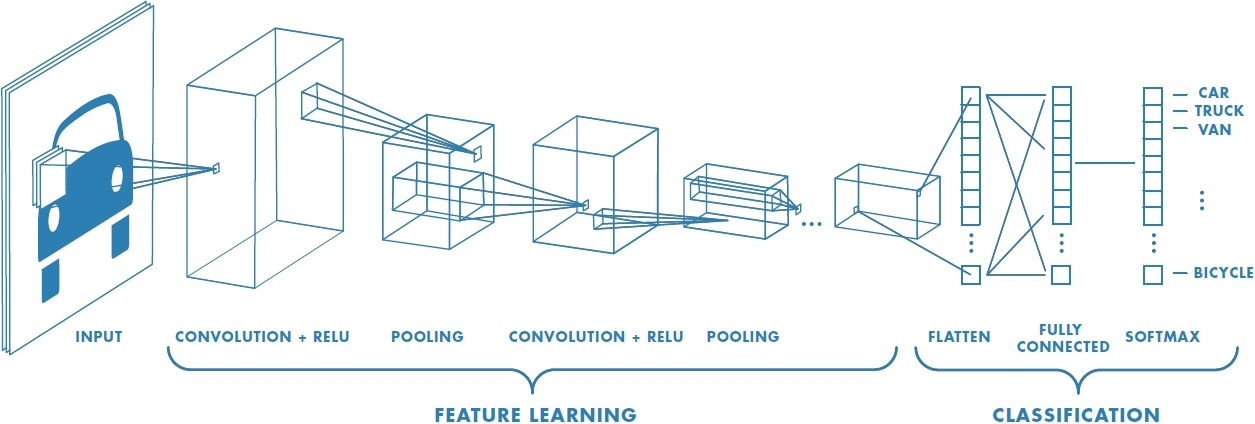

In [8]:
from IPython.display import Image
Image("C:\\Users\\kyles\\Desktop\\CNNimage.JPG")
# Diagram from MathWorks tm
# https://www.mathworks.com/discovery/convolutional-neural-network.html

Similarly to Scikit-learn, we use the .fit method to train the model. Instead of having batch size and number of epochs as parameters of the model, now we pass them to the fit method. 

The `.fit()` method returns a history object. It contains "... a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable)." https://keras.io/models/sequential/ We will not be digging into this object, everything that is needed to implement and test the model is stored in the `Sequential()` object.

In [9]:
history = model.fit(Xtrain, Ytrain,
          batch_size=batch_size,
          epochs=n_epochs,
          verbose=2)

Epoch 1/16
 - 44s - loss: 0.6694 - categorical_accuracy: 0.7895
Epoch 2/16
 - 41s - loss: 0.1749 - categorical_accuracy: 0.9434
Epoch 3/16
 - 41s - loss: 0.1126 - categorical_accuracy: 0.9640
Epoch 4/16
 - 42s - loss: 0.0827 - categorical_accuracy: 0.9723
Epoch 5/16
 - 42s - loss: 0.0667 - categorical_accuracy: 0.9781
Epoch 6/16
 - 42s - loss: 0.0542 - categorical_accuracy: 0.9828
Epoch 7/16
 - 42s - loss: 0.0458 - categorical_accuracy: 0.9855
Epoch 8/16
 - 42s - loss: 0.0407 - categorical_accuracy: 0.9865
Epoch 9/16
 - 42s - loss: 0.0349 - categorical_accuracy: 0.9888
Epoch 10/16
 - 42s - loss: 0.0296 - categorical_accuracy: 0.9901
Epoch 11/16
 - 42s - loss: 0.0286 - categorical_accuracy: 0.9908
Epoch 12/16
 - 42s - loss: 0.0229 - categorical_accuracy: 0.9926
Epoch 13/16
 - 43s - loss: 0.0212 - categorical_accuracy: 0.9932
Epoch 14/16
 - 73s - loss: 0.0209 - categorical_accuracy: 0.9935
Epoch 15/16
 - 85s - loss: 0.0185 - categorical_accuracy: 0.9935
Epoch 16/16
 - 43s - loss: 0.0170 

Scikit-learn has two different options for prediction: one that will predict probabilities (when applicable) another another to predict classes. Keras `.predict()` will give us the probability of each class, then we choose the class with the maximum probabilty, this is the same as the previous two walk-throughs . 

In [10]:
# Predicts probabilities of each class
probabilites = model.predict(Xtest)
predictions = probabilites.argmax(1)
actual = Ytest.argmax(1)

In [11]:
(predictions == actual).mean()

0.98624999999999996

## **Next Steps**

This is better than before... but still just okay performance for this prediction task. Real-world applications of digit recognition are exteremly close to 100%. But this is just one of infinitely many different CNN architectures. And we are limited to what we can train on one computer in a reasonable amount of time. One future step could be to move the training into the cloud, which would allow us to paralellize operations more, and find some optimal parmaters as well as free up CPU (GPU) on the local computer.

This convolutional neural netowork starts with 2-dimensional black and white images. The same concept can be applied with 3-dimensional colored images as well. The next level of difficulty would be using colored images with more than just 10 different classes, as well as building the network from scratch in tensorflow. This gives much more flexibility with how you want to build the structure of your deep learning network. The next tutorial _(currently in progress)_ will go over doing this same process on the CIFAR-10 image data set and implementing the CNN directly with TensorFlow. The CIFAR-10 data set contains 10 different classes of colored images including: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck (https://www.kaggle.com/c/cifar-10/data). 

If you can master that task in tensorflow, the next step would be to try the ImageNet Challenge (http://www.image-net.org/). This challenge has over 14 million images and ~22,000 different labels. 

Another next step to take could be to add a time element to images and start to recognizes sets of objects in videos. This is another area I am currently exploring.

Thank you for reading!